<a href="https://colab.research.google.com/github/ateffal/omdena-projects/blob/main/daily_transactions_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import datetime

In [3]:
# Credit : https://www.kaggle.com/code/amineteffal/exercise-forecasting-with-machine-learning/edit

def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Helper class and functions for windowing data

In [4]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False, # True
      batch_size=8,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


################################################ plot method ###########################################################
def plot(self, model=None, plot_col='monthly_crimes_calculated_with_noise', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

In [5]:
# Credit https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_2_single_layer_NN.ipynb#scrollTo=Yw5jEYuBADvA
def plot_series(time, series, series_names = None, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      series_names (str or list of str) - names of series to be ploted
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(15, 8))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)
        # legend
        if series_names != None:
            plt.legend([s for s in series_names])
        else:
            plt.legend(['serie_' + str(i) for i in len(series_names)])

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)
      if series_names != None:
          plt.legend(series_names)
      else:
          plt.legend('serie_1')

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")


    # Overlay a grid on the graph
    plt.grid(True)


    # Draw the graph on screen
    plt.show()

In [6]:
def plot_series_2_axes(df, product_market, col_first_axis, col_second_axis):
    fig, ax = plt.subplots(figsize = (15, 8))
    plt.title(product_market)

    x = list(df.index) # time

    # using the twinx() for creating another
    # axes object for secondary y-Axis
    ax2 = ax.twinx()
    line_1, = ax.plot(x, df[col_first_axis], color = 'g', label = col_first_axis)
    line_2, = ax2.plot(x, df[col_second_axis], color = 'r', label = col_second_axis)

    # giving labels to the axises
    ax.set_xlabel('date')
    ax.set_ylabel(col_first_axis, color = 'g')

    # secondary y-axis label
    ax2.set_ylabel(col_second_axis, color = 'r')


    ax.legend(handles=[line_1, line_2], loc='upper left')


    plt.show()

In [7]:
daily_transactions = pd.read_csv('/content/drive/MyDrive/Daily Household Transactions.csv')

In [8]:
daily_transactions

,Unnamed: 0,Date,Mode,Category,Subcategory,Note,Amount,Income/Expense,Currency
0,0,20/09/2018 12:04:08,Cash,Transportation,Train,2 Place 5 to Place 0,30.0,Expense,INR
1,1,20/09/2018 12:03:15,Cash,Food,snacks,Idli medu Vada mix 2 plates,60.0,Expense,INR
2,2,19/09/2018,Saving Bank account 1,subscription,Netflix,1 month subscription,199.0,Expense,INR
3,3,17/09/2018 23:41:17,Saving Bank account 1,subscription,Mobile Service Provider,Data booster pack,19.0,Expense,INR
4,4,16/09/2018 17:15:08,Cash,Festivals,Ganesh Pujan,Ganesh idol,251.0,Expense,INR
...,...,...,...,...,...,...,...,...,...
2456,2456,1/1/2015,Cash,Transportation,NaN,share jeep - Place T base to top,20.0,Expense,INR
2457,2457,1/1/2015,Cash,Transportation,NaN,share auto - Place H to Place T base,20.0,Expense,INR
2458,2458,1/1/2015,Cash,Transportation,NaN,bus - brc to Place H,30.0,Expense,INR
2459,2459,1/1/2015,Cash,Food,NaN,tea,10.0,Expense,INR


In [9]:
daily_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      2461 non-null   int64  
 1   Date            2461 non-null   object 
 2   Mode            2461 non-null   object 
 3   Category        2461 non-null   object 
 4   Subcategory     1826 non-null   object 
 5   Note            1940 non-null   object 
 6   Amount          2461 non-null   float64
 7   Income/Expense  2461 non-null   object 
 8   Currency        2461 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 173.2+ KB


Transform Date to datetime

In [10]:
# change datetime type to data
daily_transactions['Date'] = daily_transactions['Date'].apply(lambda x : pd.to_datetime(x).date())

<ipython-input-10-e8fd932117b2>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  daily_transactions['Date'] = daily_transactions['Date'].apply(lambda x : pd.to_datetime(x).date())


In [11]:
daily_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      2461 non-null   int64  
 1   Date            2461 non-null   object 
 2   Mode            2461 non-null   object 
 3   Category        2461 non-null   object 
 4   Subcategory     1826 non-null   object 
 5   Note            1940 non-null   object 
 6   Amount          2461 non-null   float64
 7   Income/Expense  2461 non-null   object 
 8   Currency        2461 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 173.2+ KB


**Note : each row is an Income or Expense : column Income/Expense**

# Create a function to make prediction using classical NNET

In [12]:
def prediction_nnet_dense_layers(daily_trans_data_, features, target,
                                 lags = 6, nodes_layers=[32, 32, 32], scale_data = True):
    """
    make prediction for given commodity name and market name

    Args:
      daily_trans_data_ (dataframe) : dataframe that contains target and features
      features (list of string) - variables to be used for prediction - in fact, lag of these variables
      target (string) - variable that we want to make predictions of

    Returns:
      data, predictions -
    """
    daily_trans_data = daily_trans_data_.copy()

    # number of features
    n_features = len(features)

    # construct features and labels series
    df_features_unscaled = make_lags(daily_trans_data[features], lags).dropna()
    df_target_unscaled = daily_trans_data.loc[:,target].iloc[lags:]

    #scale data
    if scale_data:
        df_features = (df_features_unscaled - df_features_unscaled.min())/(df_features_unscaled.max()-df_features_unscaled.min())
        df_target = (df_target_unscaled - df_target_unscaled.min())/(df_target_unscaled.max()-df_target_unscaled.min())
    else:
        df_features = df_features_unscaled.copy()
        df_target = df_target_unscaled.copy()

    # separate features and target values
    daily_trans_data_features = df_features.values
    daily_trans_data_labels = df_target.values

    # create the model from nodes_layers list
    #input layer
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(nodes_layers[0], input_shape=(None,1, n_features * lags))])
    # hidden layers
    if len(nodes_layers) > 1:
        for l in nodes_layers[1:]:
            model.add(tf.keras.layers.Dense(32))
    # output layer
    model.add(tf.keras.layers.Dense(1, activation="relu"))


    # Set the training parameters
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6))

    print('shape of x : ', daily_trans_data_features.shape)
    print('shape of y : ', daily_trans_data_labels.shape)

    # Train the model
    model.fit(x = daily_trans_data_features,y = daily_trans_data_labels, epochs=600, verbose=0)

    # get predictions
    forecasts = model.predict(daily_trans_data_features)

    # get unscaled predictions
    forecasts = forecasts * (df_target_unscaled.max() - df_target_unscaled.min())
    forecasts = forecasts + df_target_unscaled.min()

    # Plot the predictions
    col_name_observed = 'observed ' + target
    col_name_predicted = 'predicted ' + target

    time = range(len(forecasts))
    plot_series(time, (df_target_unscaled.values, forecasts), (col_name_observed , col_name_predicted))

    forecasts_val = pd.DataFrame({col_name_observed : list(df_target_unscaled.values) , col_name_predicted : list(forecasts[:,0])})
    forecasts_val['diff'] = abs(forecasts_val[col_name_observed]-forecasts_val[col_name_predicted])
    forecasts_val['diff (%)'] = forecasts_val['diff']/forecasts_val[col_name_observed]
#     print('used data : ')
    used_df = pd.concat([df_features_unscaled, df_target_unscaled], axis=1)

    print(forecasts_val[['diff', 'diff (%)']].mean())
    rmse = mean_squared_error(forecasts_val[col_name_observed], forecasts_val[col_name_predicted], squared=False)
    print('Root Mean Squared Error : ', rmse)


    return used_df, forecasts_val, rmse

In [13]:
daily_transactions.columns

Index(['Unnamed: 0', 'Date', 'Mode', 'Category', 'Subcategory', 'Note',
       'Amount', 'Income/Expense', 'Currency'],
      dtype='object')

## Test the function

In [14]:
data=daily_transactions.loc[(daily_transactions['Income/Expense']=='Expense') & (daily_transactions['Category']=='Food'),:]

In [15]:
# drop the "Unnamed: 0" column
data = data.drop(['Unnamed: 0'], axis=1)


If you take a look to the data, you see that we need to group by date

In [16]:
data = data[['Date', 'Amount']].groupby('Date').sum().reset_index()
data

,Date,Amount
0,2015-01-01,610.0
1,2015-01-02,26.0
2,2015-01-03,194.0
3,2015-01-04,50.0
4,2015-01-05,20.0
...,...,...
492,2018-11-09,686.0
493,2018-12-02,228.0
494,2018-12-04,150.0
495,2018-12-05,627.0


In [17]:
data.describe()

,Amount
count,497.000000
mean,193.970020
std,268.440978
min,2.000000
25%,46.000000
50%,96.000000
75%,225.000000
max,2546.000000


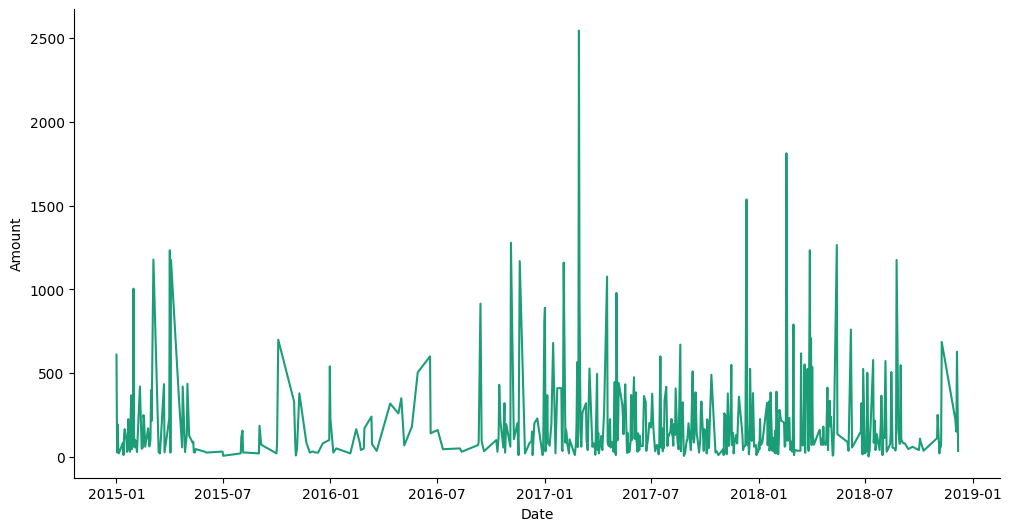

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Amount']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Amount')

shape of x :  (495, 2)
shape of y :  (495,)
16/16 [==============================] - 0s 2ms/step


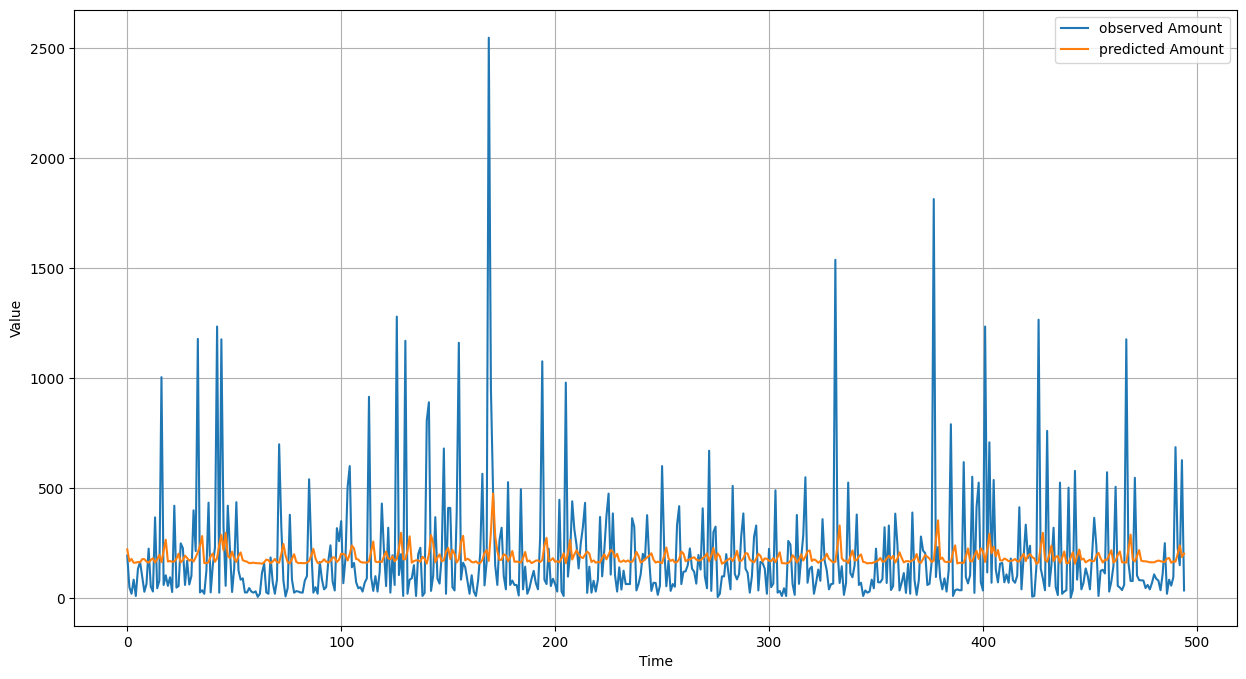

diff        168.461458
diff (%)      2.711335
dtype: float64
Root Mean Squared Error :  270.84564495507254


In [19]:
vars_features = ['Amount'] #['price', 'monthly_crimes_calculated_with_noise']
var_target = 'Amount'

selected_data, predictions, RMSE = prediction_nnet_dense_layers(data,
                                                   features = vars_features,
                                                   target = var_target,
                                                   lags = 2,
                                                   scale_data=True)



In [20]:
predictions

,observed Amount,predicted Amount,diff,diff (%)
0,194.0,221.323807,27.323807,0.140844
1,50.0,167.415344,117.415344,2.348307
2,20.0,178.050903,158.050903,7.902545
3,84.0,161.120865,77.120865,0.918106
4,10.0,161.171494,151.171494,15.117149
...,...,...,...,...
490,686.0,165.740128,520.259872,0.758396
491,228.0,199.959152,28.040848,0.122986
492,150.0,239.740204,89.740204,0.598268
493,627.0,186.780350,440.219650,0.702105


In [21]:
selected_data

,"(y_lag_1, Amount)","(y_lag_2, Amount)",Amount
2,26.0,610.0,194.0
3,194.0,26.0,50.0
4,50.0,194.0,20.0
5,20.0,50.0,84.0
6,84.0,20.0,10.0
...,...,...,...
492,96.0,57.0,686.0
493,686.0,96.0,228.0
494,228.0,686.0,150.0
495,150.0,228.0,627.0


# Classical time series forecasting - Facebook Prophet (no neural net)

> Ajouter une citation



In [22]:
from prophet import Prophet
import ee
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error

# local imports for neural net approch
# from utils import ts_models as tsm

In [24]:
# Prophet forecasting
def forecast_smap_data(dataframe, forecast_periods):
    # Reset the index to convert the datetime index to a column.
    dataframe = dataframe.reset_index()

    # Rename the columns for Prophet input requirements.
    dataframe.rename(columns={'Date': 'ds', 'Amount': 'y'}, inplace=True)

    # Create a Prophet model.
    model = Prophet()

    # Fit the model with the data.
    model.fit(dataframe)

    # Generate future dates for forecasting.
    future_dates = model.make_future_dataframe(periods=forecast_periods)

    # Make predictions for the future dates.
    forecast = model.predict(future_dates)

    return model, forecast

In [25]:
forecast_periode = 7

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk3t1gjw8/hbdqls75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk3t1gjw8/ew80lm_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87182', 'data', 'file=/tmp/tmpk3t1gjw8/hbdqls75.json', 'init=/tmp/tmpk3t1gjw8/ew80lm_m.json', 'output', 'file=/tmp/tmpk3t1gjw8/prophet_modelm5s8f7i6/prophet_model-20240518152119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


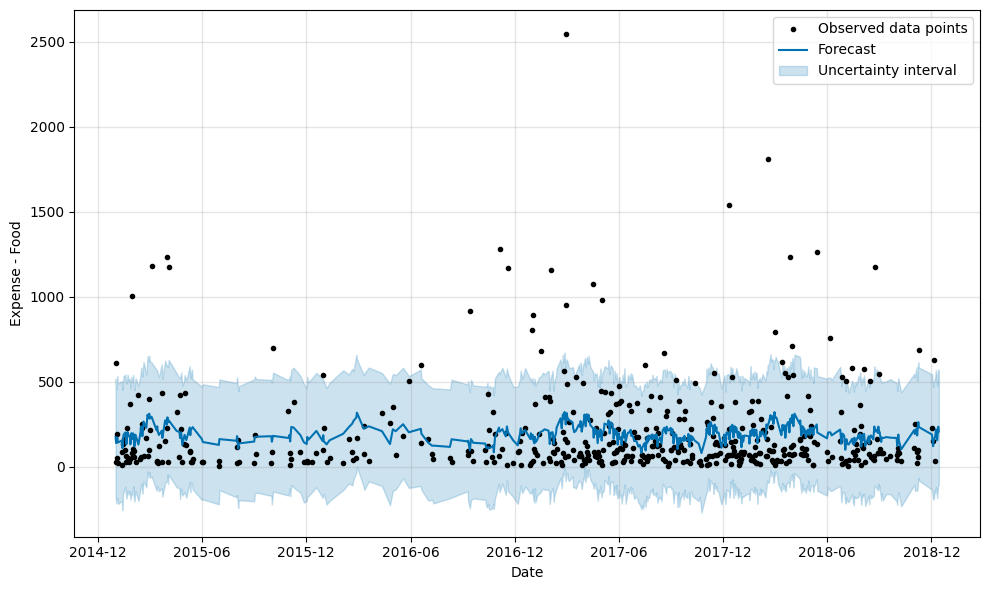

In [26]:
# Forecast the SMAP data
model, forecast = forecast_smap_data(data, forecast_periods=forecast_periode)

# Visualize the forecasted results
fig = model.plot(forecast, xlabel='Date', ylabel='Expense - Food', include_legend=True)

In [27]:
forecast[['ds', 'yhat']]

,ds,yhat
0,2015-01-01,174.406634
1,2015-01-02,138.717500
2,2015-01-03,144.893870
3,2015-01-04,170.467250
4,2015-01-05,142.343269
...,...,...
499,2018-12-10,197.985805
500,2018-12-11,155.951081
501,2018-12-12,191.745806
502,2018-12-13,235.159775


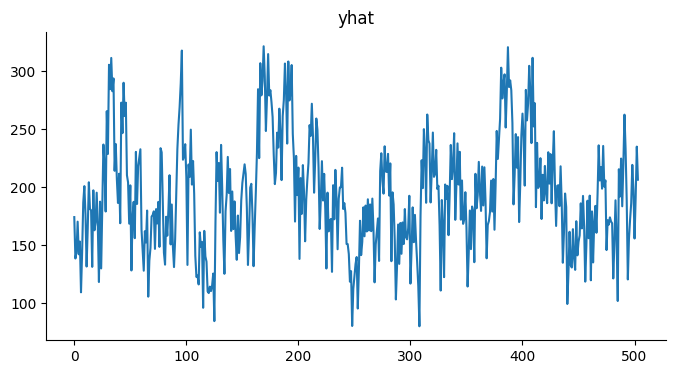

In [ ]:
from matplotlib import pyplot as plt
_df_3['yhat'].plot(kind='line', figsize=(8, 4), title='yhat')
plt.gca().spines[['top', 'right']].set_visible(False)

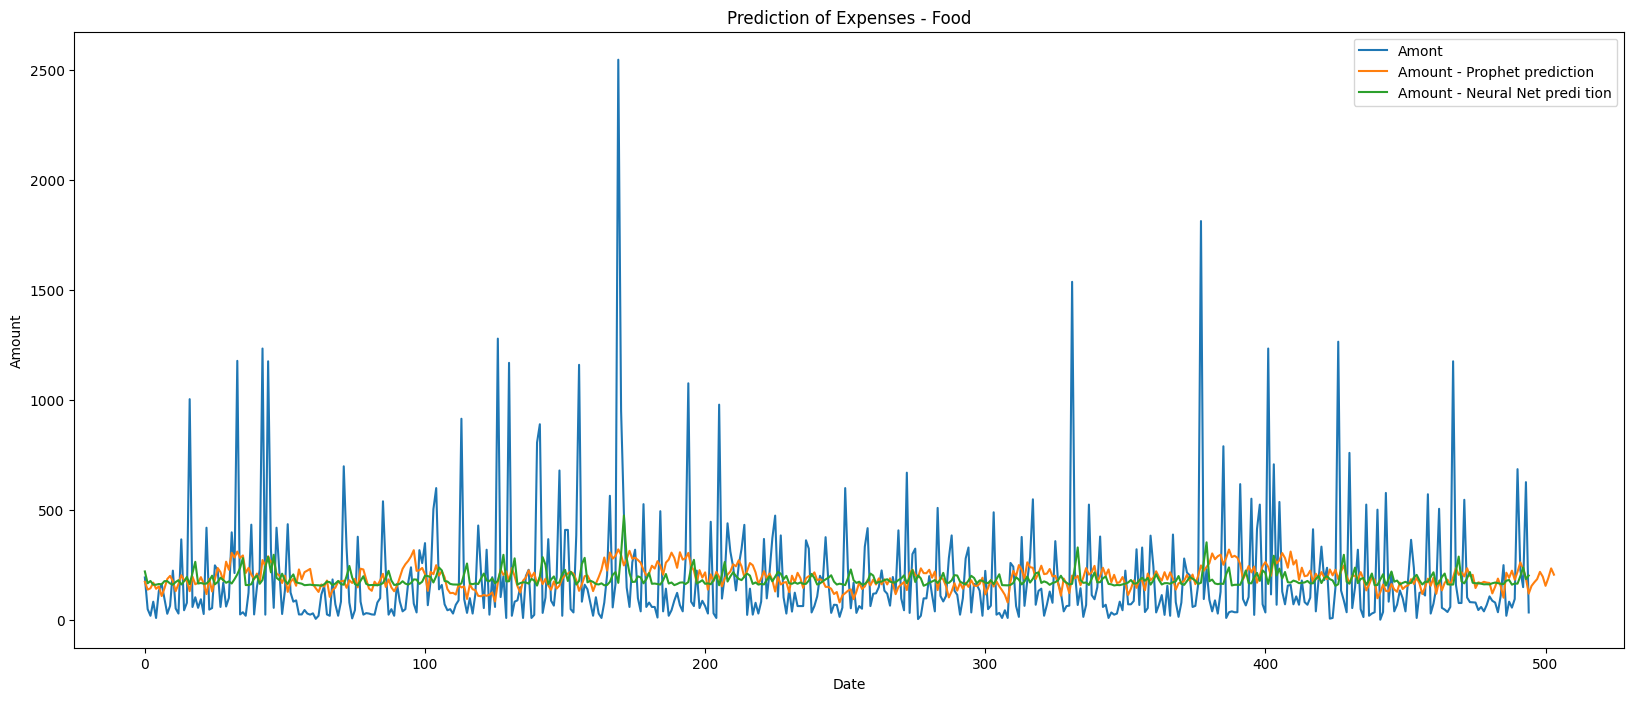

In [41]:
fig = plt.figure(figsize=(20, 8))
plt.plot(predictions[['observed Amount']], label="Amont")
plt.plot(forecast[['yhat']], label="Amount - Prophet prediction")
plt.plot(predictions['predicted Amount'], label="Amount - Neural Net predi tion")

# Add a title and axes labels
plt.title("Prediction of Expenses - Food")
plt.xlabel("Date")
plt.ylabel("Amount")

# Add a legend
plt.legend()

# Show the plot
plt.show()



